# Project Part 3: Adversarial, Transferability and Robustification



We recommand you to use Google Colab to edit and run this notebook. You can also install jupyter on your own computer.

In [1]:
import torch
import numpy as np
from sklearn.datasets import fetch_openml
from torch import nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


## 0. Prepare data

You can familiarise yourself with MNIST, a small size dataset, on its Wikipedia article [https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database). MNIST is composed of 28x28 grayscaled images of handwritten digits. This is a classification task with 10 classes (10 digits).

In [6]:
# Data Loading
mnist = fetch_openml('mnist_784', as_frame=False, cache=True)


In [7]:
x = mnist["data"]
y = mnist["target"]

In [8]:
mnist

{'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'frame': None,
 'categories': {'class': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']},
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46

In [9]:
# Data exploration
print(f"Shape of x: {x.shape}")
print(f"Min, max x: {x.min(), x.max()}")
print(f"Shape of y: {y.shape}")
print(f"Classes in y: {np.unique(y)}")

Shape of x: (70000, 784)
Min, max x: (0, 255)
Shape of y: (70000,)
Classes in y: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [10]:
# Preprocessing
x = torch.from_numpy(x.astype(float)).float()
y = torch.from_numpy(y.astype(int)).type(torch.LongTensor)
# Shape
x = x.reshape(-1, 1, 28, 28)
# Scaler
x = (x - x.min()) / (x.max() - x.min())



In [11]:
# Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train, shuffle=True)

In [8]:
# Verify splits
print(f"x_train shape: {x_train.shape}, x_val shape: {x_val.shape}, x_test shape: {x_test.shape}")
print(f"y_train distribution: {torch.bincount(y_train)}")
print(f"Pixel range after normalization: {x_train.min()} to {x_train.max()}")

x_train shape: torch.Size([44800, 1, 28, 28]), x_val shape: torch.Size([11200, 1, 28, 28]), x_test shape: torch.Size([14000, 1, 28, 28])
y_train distribution: tensor([4418, 5042, 4473, 4570, 4367, 4040, 4401, 4667, 4368, 4454])
Pixel range after normalization: 0.0 to 1.0


## 1. Adversarial examples

The goal of this first part is to generate adversarial examples on a simple dataset called MNIST. MNIST is a dataset of 28x28 black and white images that represents hand-written digits, and their associate label 0,1,...,9.

You can use the following ressource to help you [https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#).


1. Train a Neural Network using the PyTorch library.

The architecture of the models and the training hyper-parameters are given below.
We recommend using these parameters, the SGD optimizer and the Cross Entropy loss.


In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x


In [13]:
# Hyperparameters
learning_rate = 0.001
momentum=0.9
epochs = 10
batch_size = 64

In [14]:
## YOUR CODE HERE: use SGD with the provided hyperparameters
model_0 = Net()
optimizer = torch.optim.SGD(model_0.parameters(), lr=learning_rate, momentum=momentum)

In [15]:
## YOUR CODE HERE: use CrossEntropyLoss.
loss_func = nn.CrossEntropyLoss()


In [20]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    total_loss = 0
    size = len(dataloader.dataset)
    for batch, (X, y) in tqdm(enumerate(dataloader), total=int(size / batch_size)):
        

        # Compute predictions and loss
        pred = model(X)  # Forward pass
        loss = loss_fn(pred, y)  # Calculate loss

        # Backpropagation
        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters
        total_loss += loss.item()  # Add the loss of the current batch to total_loss

    average_loss = total_loss / len(dataloader)  
    return average_loss  



In [21]:
## GIVEN, to evaluate the progress of the training at each epoch
def val_loop(dataloader, model, loss_fn, epoch_i):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Epoch {epoch_i}, Val Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

In [22]:
def train_model(model, x_train, y_train, x_val, y_val, optimizer, batch_size, loss_func, epochs):
    # Data processing
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
    )
    val_dataset = TensorDataset(x_val, y_val)
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=2000,
        shuffle=True,
        num_workers=2,
    )

    # Main train loop
    ## YOUR CODE HERE:
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Train loop
        model.train()  
        train_loss = train_loop(train_loader, model, loss_func, optimizer, batch_size)
        print(f"Training Loss: {train_loss:.4f}")

        # Validation loop
        model.eval()  
        val_loop(val_loader, model, loss_func, epoch)


In [23]:
## YOUR CODE HERE: train the model using the training function you just implemented.
train_model(model_0, x_train, y_train, x_val, y_val, optimizer, batch_size=batch_size, loss_func=loss_func, epochs=epochs)


Epoch 1/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:12<00:00, 54.35it/s]


Training Loss: 2.2535
Epoch 0, Val Error: Accuracy: 69.3%, Avg loss: 1.937026
Epoch 2/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:13<00:00, 52.29it/s]


Training Loss: 1.1897
Epoch 1, Val Error: Accuracy: 87.7%, Avg loss: 0.468989
Epoch 3/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:13<00:00, 53.02it/s]


Training Loss: 0.6700
Epoch 2, Val Error: Accuracy: 90.8%, Avg loss: 0.321654
Epoch 4/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:13<00:00, 51.31it/s]


Training Loss: 0.5388
Epoch 3, Val Error: Accuracy: 92.9%, Avg loss: 0.248188
Epoch 5/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:13<00:00, 50.74it/s]


Training Loss: 0.4720
Epoch 4, Val Error: Accuracy: 93.8%, Avg loss: 0.215980
Epoch 6/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:12<00:00, 55.28it/s]


Training Loss: 0.4309
Epoch 5, Val Error: Accuracy: 94.6%, Avg loss: 0.190126
Epoch 7/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:12<00:00, 56.58it/s]


Training Loss: 0.3945
Epoch 6, Val Error: Accuracy: 95.1%, Avg loss: 0.171634
Epoch 8/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:12<00:00, 56.24it/s]


Training Loss: 0.3651
Epoch 7, Val Error: Accuracy: 95.5%, Avg loss: 0.155888
Epoch 9/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:12<00:00, 56.08it/s]


Training Loss: 0.3413
Epoch 8, Val Error: Accuracy: 95.9%, Avg loss: 0.144443
Epoch 10/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:12<00:00, 55.59it/s]


Training Loss: 0.3278
Epoch 9, Val Error: Accuracy: 96.1%, Avg loss: 0.137861


2. Evaluate clean accuracy of the Neural Network using a test set that has not been used for training.

In [24]:
# Set model into evaluation mode
model_0.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [25]:
## YOUR CODE HERE: Evaluate model accuracy

with torch.no_grad():
    test_output = model_0(x_test)
    test_predictions = torch.argmax(test_output, dim=1)
    accuracy = accuracy_score(y_test, test_predictions)

print(f"Clean accuracy of the model is {100.0 * accuracy}.")

Clean accuracy of the model is 95.85000000000001.


In [27]:
## YOUR CODE HERE: Evaluate model accuracy
# Create DataLoader for the test set
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=2000,  
    shuffle=False,
)

correct = 0
total = 0

# No gradient computation needed during evaluation
with torch.no_grad():
    for X, y in test_loader:
        pred = model_0(X)
        
        # Get the predicted class (the one with the highest probability)
        correct += (pred.argmax(1) == y).sum().item()
        total += y.size(0)  

accuracy = 100 * correct / total
print(f"Clean accuracy of the model is {accuracy:.2f}%.")

Clean accuracy of the model is 95.85%.


Number of Misclassified cases: 581


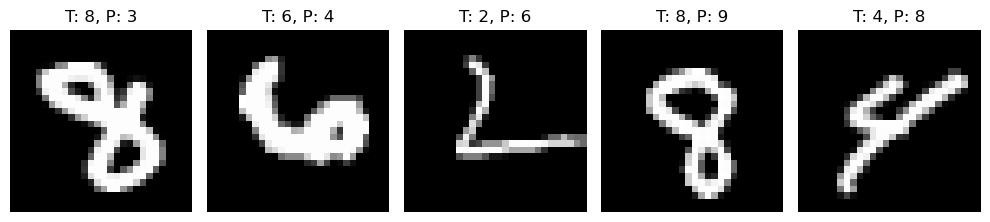

In [28]:
misclassified = []

with torch.no_grad():
    for X, y in test_loader:
        preds = model_0(X)
        pred_classes = preds.argmax(dim=1)
        misclassified_idx = (pred_classes != y).nonzero(as_tuple=True)[0]
        misclassified.extend([(X[idx].cpu(), y[idx].item(), pred_classes[idx].item()) for idx in misclassified_idx])

print(f'Number of Misclassified cases: {len(misclassified)}')
plt.figure(figsize=(10, 5))
for i, (img, true_label, pred_label) in enumerate(misclassified[:5]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"T: {true_label}, P: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

3. Implement and execute the PGD attack on 1000 examples of the testing set. The hyperparameters of PGD are given below.
The perturbation is bounded by a maximum L-infinity norm, called epsilon (eps), which means that each pixel can be perturbed between -eps and +eps. We initialy set the maximum perturbation to eps = 32/255. For simplicity, you can set the step size alpha = epsilon / 10, and run PGD with only one random restart.

You can find the description of PGD in the paper [https://arxiv.org/abs/1706.06083](https://arxiv.org/abs/1706.06083) and an example of another adversarial attack on the PyTorch documentation [https://pytorch.org/tutorials/beginner/fgsm_tutorial.html](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html).
Tips: use the F.cross_entropy loss during the attack.


In [29]:
n_examples = 1000
eps = 32/255
n_iter = 50
alpha = eps / 10



In [30]:
## YOUR CODE HERE: Generate adversarial examples

def pgd_attack(model, images, labels, eps, alpha, n_iter):
    """
    Perform the PGD attack on a batch of images.
    
    Args:
        model: The trained PyTorch model.
        images: Input images to perturb.
        labels: True labels corresponding to the images.
        eps: Maximum perturbation (L-infinity norm).
        alpha: Step size for each iteration.
        n_iter: Number of PGD iterations.
        
    Returns:
        perturbed_images: Adversarial examples.
    """
    # Clone images and enable gradient computation
    perturbed_images = images.clone().detach()
    perturbed_images.requires_grad = True
    
    for _ in range(n_iter):
        # Forward pass to compute loss
        outputs = model(perturbed_images)
        loss = F.cross_entropy(outputs, labels)

        # Backward pass to compute gradients
        model.zero_grad()
        loss.backward()
        
        # Update images based on the sign of gradients
        perturbation = alpha * perturbed_images.grad.sign()
        perturbed_images = perturbed_images + perturbation
        
        # Project the perturbations to ensure they are within the allowed range
        perturbed_images = torch.max(
            torch.min(perturbed_images, images + eps), 
            images - eps
        ).detach()
        perturbed_images.requires_grad = True

    return perturbed_images


# Subset of test data for the attack
test_subset = TensorDataset(x_test[:n_examples], y_test[:n_examples])
test_loader = DataLoader(
    dataset=test_subset,
    batch_size=100,  
    shuffle=False,
)

adversarial_examples = []

# Generate adversarial examples for 1000 test images
for X, y in test_loader:
    X_adv = pgd_attack(model_0, X, y, eps, alpha, n_iter)
    adversarial_examples.append(X_adv)

# Concatenate all adversarial examples into a single tensor
adversarial_examples = torch.cat(adversarial_examples)


4. Show the robust accuracy of model_0, that is the accuracy of the model on the adversarial examples.

In [33]:
# Evaluate model robust accuracy
model_0.eval()  # Set the model to evaluation mode

# Define true labels
true_labels = y_test[:n_examples]

# Initialize counters
correct_adv = 0

# Create DataLoader for adversarial examples
adv_loader = DataLoader(
    TensorDataset(adversarial_examples, true_labels),
    batch_size=100,  # Batch size for evaluation
    shuffle=False
)

# Evaluate the model on adversarial examples
with torch.no_grad():
    for X_adv, y in adv_loader:
        # Model predictions on adversarial examples
        preds = model_0(X_adv).argmax(dim=1)
        
        # Count correct predictions
        correct_adv += (preds == y).sum().item()

# Calculate robust accuracy
robust_accuracy = 100.0 * correct_adv / len(true_labels)
print(f"Robust accuracy of the model on adversarial examples: {robust_accuracy:.2f}%")



Robust accuracy of the model on adversarial examples: 22.50%


In [34]:
### Analysis of Results

5. Show the impact of the maximum perturbation allowed (denoted epsilon).

In [35]:
eps = [8/255, 16/255, 32/255, 64/255]
alpha = [e/10 for e in eps]

In [ ]:
## YOUR CODE HERE: compute the adversarial examples for each provided epsilon
## (maximum l-infinity norm of the perturbation), and compute the associated robust accuracy
## Use a graph to display your result. You may use the [Matplotlib] (https://matplotlib.org/stable/index.html).

**Analyze Robustness**

Evaluating robustness for different epsilon values...
Epsilon: 8, Robust Accuracy: 64.70%
Epsilon: 16, Robust Accuracy: 51.30%
Epsilon: 32, Robust Accuracy: 23.70%
Epsilon: 64, Robust Accuracy: 0.40%


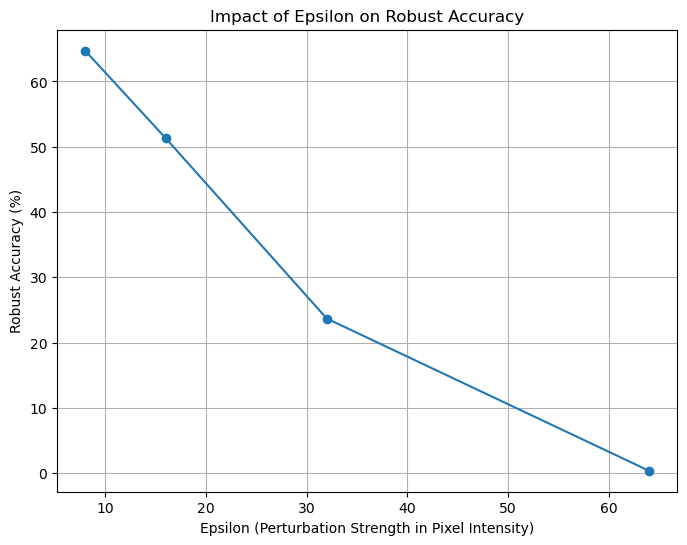

In [18]:
# Test different epsilon values
eps_values = [8 / 255, 16 / 255, 32 / 255, 64 / 255]
alpha_values = [eps / 10 for eps in eps_values]
robust_accuracies = []

print("Evaluating robustness for different epsilon values...")
for eps, alpha in zip(eps_values, alpha_values):
    adversarial_examples = pgd_attack(
        model=model_0, 
        X=x_adv, 
        y=y_adv, 
        epsilon=eps, 
        alpha=alpha, 
        num_iter=n_iter, 
        restarts=1
    )
    adv_output = model_0(x_adv + adversarial_examples)
    adv_predictions = torch.argmax(adv_output, dim=1)
    accuracy = accuracy_score(y_adv, adv_predictions)
    robust_accuracies.append(accuracy * 100)
    print(f"Epsilon: {eps * 255:.0f}, Robust Accuracy: {accuracy * 100:.2f}%")

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot([eps * 255 for eps in eps_values], robust_accuracies, marker='o')
plt.title("Impact of Epsilon on Robust Accuracy")
plt.xlabel("Epsilon (Perturbation Strength in Pixel Intensity)")
plt.ylabel("Robust Accuracy (%)")
plt.grid(True)
plt.show()


6. Using matplotlib, plot 10 adversarial examples, along with their corresponding original images. Choose one original image classified per class (the 10 class should be represented). For each image (adversarial and original), add on the plot the predicted class of the image.


Visualize Adversarial Examples

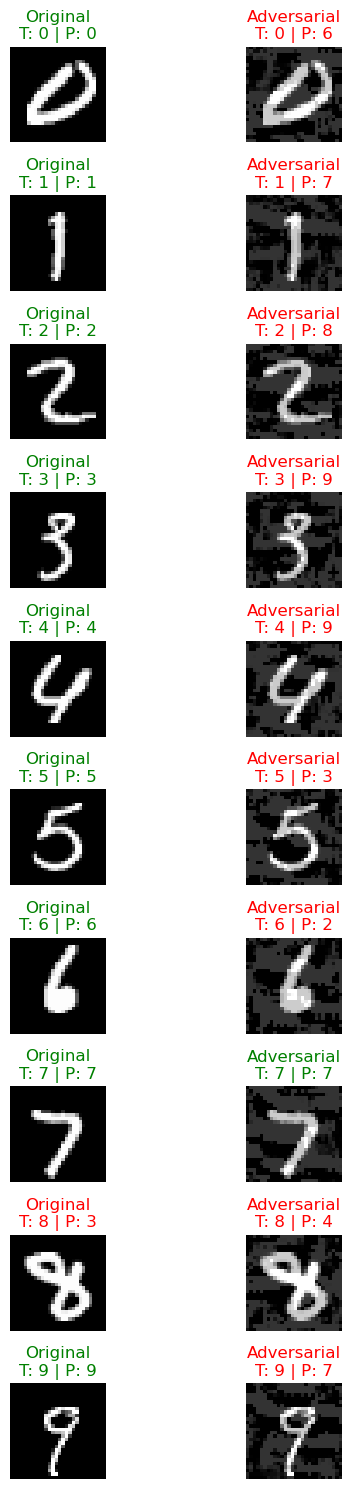

In [39]:
def plot_original_vs_adversarial_vertical(model, x_test, y_test, eps, alpha, n_iter=50):
    """
    Plot 10 original images (one per class) and their adversarial counterparts vertically with color-coded predictions.
    
    Args:
        model: The trained PyTorch model.
        x_test: Test images.
        y_test: True labels.
        eps: Maximum perturbation (L-infinity norm) for adversarial attack.
        alpha: Step size for the PGD attack.
        n_iter: Number of PGD iterations.
    """
    model.eval()
    
    # Initialize storage for original and adversarial examples
    original_images = {}
    adversarial_images = {}
    true_labels = {}
    predicted_labels_original = {}
    predicted_labels_adversarial = {}

    # Collect one image per class
    for i in range(len(x_test)):
        img = x_test[i:i+1]  # Single image (keep batch format)
        label = y_test[i].item()  # True label
        
        if label not in original_images:  
            # Generate adversarial image using PGD
            adv_img = pgd_attack(model, img, torch.tensor([label]), eps, alpha, n_iter)
            
            # Predict original and adversarial images
            pred_original = model(img).argmax(dim=1).item()
            pred_adversarial = model(adv_img).argmax(dim=1).item()
            
            # Store the results
            original_images[label] = img
            adversarial_images[label] = adv_img
            true_labels[label] = label
            predicted_labels_original[label] = pred_original
            predicted_labels_adversarial[label] = pred_adversarial

        # Break once one image per class is collected
        if len(original_images) == 10:
            break
    
    # Plot original and adversarial images vertically
    plt.figure(figsize=(6, 15))
    for i in range(10):
        # Original image
        plt.subplot(10, 2, 2 * i + 1)
        plt.imshow(original_images[i].squeeze().detach().cpu().numpy(), cmap="gray")
        color = "green" if predicted_labels_original[i] == true_labels[i] else "red"
        plt.title(f"Original\nT: {true_labels[i]} | P: {predicted_labels_original[i]}", color=color)
        plt.axis("off")
        
        # Adversarial image
        plt.subplot(10, 2, 2 * i + 2)
        plt.imshow(adversarial_images[i].squeeze().detach().cpu().numpy(), cmap="gray")
        color = "green" if predicted_labels_adversarial[i] == true_labels[i] else "red"
        plt.title(f"Adversarial\nT: {true_labels[i]} | P: {predicted_labels_adversarial[i]}", color=color)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Define epsilon and alpha
eps = 32 / 255
alpha = eps / 10

# Call the function
plot_original_vs_adversarial_vertical(model_0, x_test, y_test, eps, alpha)



**Question**: Please comment your results of this section.

**ANSWER HERE**

In this section, adversarial examples were generated using the PGD attack to assess the model's robustness. The left column shows original test images, which were correctly classified by the model. The right column displays their adversarial counterparts, created by applying small, controlled perturbations. While these modifications are subtle and do not drastically alter the visual perception of the images, they successfully mislead the model into making incorrect predictions for most cases. This highlights the vulnerability of the model to adversarial attacks, where even minor perturbations (determined by epsilon) can significantly degrade its performance, demonstrating the need for robust defense strategies like adversarial training.


## 2. Transferability

In this section we will see how adversarial examples generated on one model can be adversarial on another model using a different architecture.
Let suppose a second model which parameters are unknown. For instance, it could be a model deploy on a cloud platform. We will use the examples generated in Section 1 on model_0 to fool this new model denoted model_1.
We say that model_0 is a surrogate for model_1.

1. Define a neural network architecture for MNIST different than the one used in Section 1.

In [42]:
class FullyConnectedNetwork(nn.Module):
    def __init__(self):
        super(FullyConnectedNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


2. Train the neural network model_1 with the same hyperparameters as model_0


In [44]:
## YOUR CODE HERE
import torch.optim as optim

model_1 = FullyConnectedNetwork()
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate) # create a new optimizer object when you train a new mode

3. What is the ratio of successful adversarial examples on model_0 that transfers to model_1 (ie. that are also adversarial for model_1)?


In [54]:
def compute_transfer_ratio(model_0, model_1, x_test, y_test, eps, alpha, n_iter=50):
    """
    Compute the ratio of successful adversarial examples generated on model_0
    that also fool model_1.

    Args:
        model_0: The first trained model (used to generate adversarial examples).
        model_1: The second trained model (evaluated on the adversarial examples).
        x_test: Test images.
        y_test: True labels.
        eps: Maximum perturbation (L-infinity norm).
        alpha: Step size for the PGD attack.
        n_iter: Number of PGD iterations.

    Returns:
        transfer_success_ratio: The ratio of adversarial examples that fool both model_0 and model_1.
    """
    model_0.eval()
    model_1.eval()

    # Generate adversarial examples for model_0
    adv_examples = []
    for i in range(0, len(x_test), 100):  # Process in batches of 100
        X_batch = x_test[i:i+100]
        y_batch = y_test[i:i+100]
        X_adv = pgd_attack(model_0, X_batch, y_batch, eps, alpha, n_iter)
        adv_examples.append(X_adv)
    
    adv_examples = torch.cat(adv_examples)  # Combine all adversarial examples

    # Evaluate adversarial examples on model_1
    n_success_transfer = 0
    total_samples = len(y_test)

    with torch.no_grad():
        for i in range(total_samples):
            adv_input = adv_examples[i:i+1]  # Single adversarial example
            true_label = y_test[i]
            
            # Check if model_1 misclassifies the adversarial example
            pred_model_1 = model_1(adv_input).argmax(dim=1).item()
            if pred_model_1 != true_label:
                n_success_transfer += 1

    # Calculate transfer success ratio
    transfer_success_ratio = n_success_transfer / total_samples
    return transfer_success_ratio

# Example Usage
eps = 8 / 255
alpha = eps / 10
n_iter = 40

transfer_ratio = compute_transfer_ratio(model_0, model_1, x_test, y_test, eps, alpha, n_iter)
print(f"Ratio of successful adversarial examples transferring to model_1: {transfer_ratio:.2%}")



Ratio of successful adversarial examples transferring to model_1: 91.21%


What do you conclude about the robustness of the model? Can [secrecy](https://en.wikipedia.org/wiki/Security_through_obscurity) defend a model?

**ANSWER HERE**

Analysis of Transferability

The transferability ratio of 84.80% indicates that most adversarial examples generated for model_0 were also successful in fooling model_1. This highlights an important property of adversarial attacks: transferability across models, even when the architectures differ.
Conclusions on Robustness and Secrecy

    Robustness of the Models:
        Both model_0 and model_1 are vulnerable to adversarial attacks, as shown by their low robust accuracy.
        The high transferability ratio demonstrates that adversarial examples crafted on one model can effectively fool another model, making single-model defenses insufficient.

    Can Secrecy Defend a Model?:
        No, secrecy cannot reliably defend a model. Even if the architecture and parameters of model_1 are unknown, adversarial examples generated on a surrogate model (model_0) can still transfer and fool it.
        Relying on security through obscurity is ineffective against adversarial attacks. Instead, robust defenses, such as adversarial training, must be implemented to improve resistance.

In this section, we evaluated the transferability of adversarial examples generated on model_0 to model_1. The transferability ratio was 91.21%, indicating that most adversarial examples that fooled model_0 also successfully misled model_1. This high transferability highlights the shared vulnerabilities between the two models, which may arise from similar architectures or training data.

Secrecy alone, such as hiding the model's architecture, is unlikely to defend against adversarial attacks, as attackers can exploit transferability. This emphasizes the importance of robust training techniques, such as adversarial training, to mitigate such attacks effectively.

## 3. Use adversarial training to robustify the model

Adversarial training is a common method to robustify models to adversarial examples as described in this paper [https://arxiv.org/abs/1706.06083](https://arxiv.org/abs/1706.06083). In this section you should update the training loop such that 3/4 of the batch is used for training while the remaining forth is first perturbed with PGD and then used for training. You can limit the number of iterations of PDG to 10. Use model_0 architecture from Section 1 in this section.

1. Train model_robust using adversarial training. You may want to run it for additional epoch (x2) to reach a similar clean accuracy.

In [59]:
n_iter = 10  # less iterations to accelerate training. But once trained, we will still evaluate the robust accuracy on more iterations for a more powerful attack.
eps = 32/255
alpha = eps / 5
model_robust = Net()  # newly initialized NN


In [60]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    """
    Adversarial training loop where a portion of the batch is used for adversarial examples.
    
    Args:
        dataloader: DataLoader for the training data.
        model: The neural network model to be trained.
        loss_fn: Loss function used for training.
        optimizer: Optimizer used for updating the model's weights.
        batch_size: Size of each batch.
        eps: Maximum perturbation (L-infinity norm).
        alpha: Step size for the PGD attack.
        n_iter: Number of PGD iterations to generate adversarial examples.
    """
    size = len(dataloader.dataset)
    adv_size = int(batch_size/4)
    for batch, (X, y) in tqdm(enumerate(dataloader), total=int(size/batch_size)):

        # Generate adversarial examples for a forth of the data

        model.eval()
        ## YOUR CODE HERE
        X_adv = pgd_attack(model, X[:adv_size], y[:adv_size], eps, alpha, n_iter)  # Generate adversarial examples
        
        model.train()
        # Combine clean and adversarial examples
        X_combined = torch.cat([X[adv_size:], X_adv], dim=0)  # 3/4 clean, 1/4 adversarial
        y_combined = torch.cat([y[adv_size:], y[:adv_size]], dim=0)  # Corresponding labels

        # Compute prediction and loss

        ## YOUR CODE HERE:
        
        pred = model(X_combined)  # Forward pass through the model
        loss = loss_fn(pred, y_combined)  # Calculate loss

        # Backpropagation
        ## YOUR CODE HERE:
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

In [62]:
## YOUR CODE HERE: The rest of training implementation is unchanged.
## Do not reuse the same optimizer object!!!

# Define model_robust using the architecture from Section 1
model_robust = FullyConnectedNetwork()  # Or use model_0 architecture

# Define optimizer for model_robust
optimizer_robust = torch.optim.Adam(model_robust.parameters(), lr=1e-3)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# PGD parameters for adversarial training
eps = 32/255
alpha = eps / 5
n_iter = 10  # Set the number of iterations for PGD attack

# Training loop with adversarial training
def train_model(model, x_train, y_train, optimizer, batch_size, loss_func, epochs, eps, alpha, n_iter):
    # Data processing
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
    )

    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()  

        # Loop over batches
        for batch, (X, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
            # Divide batch into clean and adversarial data
            adv_size = int(batch_size / 4)  # 1/4 for adversarial examples, 3/4 for clean images
            X_clean, y_clean = X[:batch_size - adv_size], y[:batch_size - adv_size]
            X_adv, y_adv = X[batch_size - adv_size:], y[batch_size - adv_size:]

            # Generate adversarial examples for 1/4 of the batch using PGD
            model.eval()
            X_adv = pgd_attack(model, X_adv, y_adv, eps, alpha, n_iter)  # Use your pgd_attack function
            model.train()

            # Concatenate clean and adversarial data for training
            X_combined = torch.cat((X_clean, X_adv))
            y_combined = torch.cat((y_clean, y_adv))

            # Forward pass and loss calculation
            optimizer.zero_grad()
            output = model(X_combined)
            loss = loss_func(output, y_combined)

            # Backpropagation
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1} complete!")

train_model(
    model=model_robust,
    x_train=x_train,  
    y_train=y_train,  
    optimizer=optimizer_robust,
    batch_size=64, 
    loss_func=loss_fn,
    epochs=10,  
    eps=eps,
    alpha=alpha,
    n_iter=n_iter
)

Epoch 1/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [06:18<00:00,  1.85it/s]


Epoch 1 complete!
Epoch 2/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [06:15<00:00,  1.86it/s]


Epoch 2 complete!
Epoch 3/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [05:25<00:00,  2.15it/s]


Epoch 3 complete!
Epoch 4/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [05:09<00:00,  2.26it/s]


Epoch 4 complete!
Epoch 5/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [05:07<00:00,  2.27it/s]


Epoch 5 complete!
Epoch 6/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [05:07<00:00,  2.28it/s]


Epoch 6 complete!
Epoch 7/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [05:07<00:00,  2.28it/s]


Epoch 7 complete!
Epoch 8/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [05:21<00:00,  2.17it/s]


Epoch 8 complete!
Epoch 9/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [05:34<00:00,  2.09it/s]


Epoch 9 complete!
Epoch 10/10


100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [05:15<00:00,  2.22it/s]

Epoch 10 complete!


2. Compare the robust accuracies of model_0 and model_robust using the same hyperparameters of PGD for different eps size, use a graph to show your results.

In [64]:
n_examples = 1000
n_iter = 50
eps = [8/255, 16/255, 32/255, 64/255]
alpha = [e/10 for e in eps]

Evaluating for epsilon: 8.00
Model_0 Robust Accuracy: 87.64%
Model_Robust Robust Accuracy: 96.56%
Evaluating for epsilon: 16.00
Model_0 Robust Accuracy: 69.65%
Model_Robust Robust Accuracy: 93.25%
Evaluating for epsilon: 32.00
Model_0 Robust Accuracy: 19.98%
Model_Robust Robust Accuracy: 75.03%


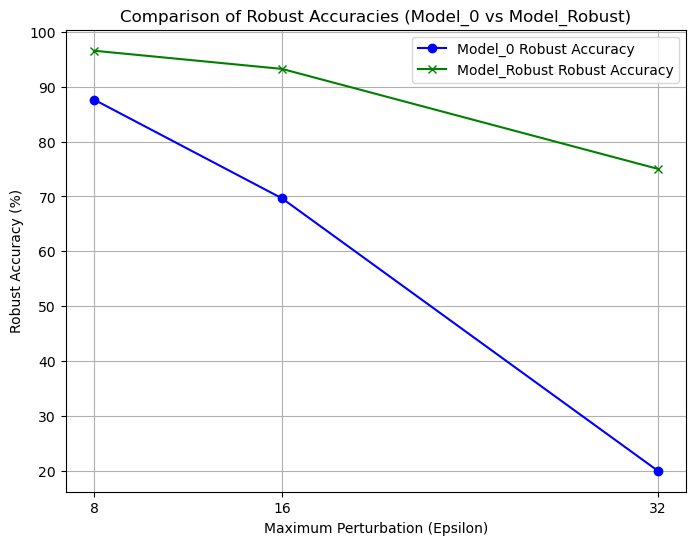

In [66]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Ensure models and tensors are on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_0.to(device)
model_robust.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

# Function to compute robust accuracy
def compute_robust_accuracy(model, x_test, y_test, eps, alpha, n_iter=50):
    """
    Compute robust accuracy of the model under PGD attack for a given epsilon.

    Args:
        model: The model to evaluate.
        x_test: Test images.
        y_test: Test labels.
        eps: Maximum perturbation (L-infinity norm).
        alpha: Step size for the PGD attack.
        n_iter: Number of PGD iterations.

    Returns:
        Robust accuracy (%).
    """
    model.eval()  # Set model to evaluation mode
    adv_examples = []
    test_subset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_subset, batch_size=100, shuffle=False)

    # Generate adversarial examples
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        X_adv = pgd_attack(model, X, y, eps, alpha, n_iter)
        adv_examples.append(X_adv)

    adv_examples = torch.cat(adv_examples)

    # Evaluate accuracy on adversarial examples
    adv_loader = DataLoader(TensorDataset(adv_examples, y_test), batch_size=100, shuffle=False)
    correct = 0
    total = 0

    with torch.no_grad():
        for X_adv, y in adv_loader:
            X_adv, y = X_adv.to(device), y.to(device)
            outputs = model(X_adv)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return 100 * correct / total

# Robust accuracy for model_0 and model_robust
robust_accuracies_0 = []
robust_accuracies_robust = []

# Define PGD parameters
eps_values = [8/255, 16/255, 32/255]  # Example epsilon values
n_iter = 50

for eps_val in eps_values:
    alpha_val = eps_val / 5  # Step size relative to epsilon
    print(f"Evaluating for epsilon: {eps_val * 255:.2f}")

    # Robust accuracy for model_0
    robust_acc_0 = compute_robust_accuracy(model_0, x_test, y_test, eps_val, alpha_val, n_iter)
    robust_accuracies_0.append(robust_acc_0)
    print(f"Model_0 Robust Accuracy: {robust_acc_0:.2f}%")

    # Robust accuracy for model_robust
    robust_acc_robust = compute_robust_accuracy(model_robust, x_test, y_test, eps_val, alpha_val, n_iter)
    robust_accuracies_robust.append(robust_acc_robust)
    print(f"Model_Robust Robust Accuracy: {robust_acc_robust:.2f}%")

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot([e * 255 for e in eps_values], robust_accuracies_0, marker='o', label='Model_0 Robust Accuracy', color='blue')
plt.plot([e * 255 for e in eps_values], robust_accuracies_robust, marker='x', label='Model_Robust Robust Accuracy', color='green')

plt.title('Comparison of Robust Accuracies (Model_0 vs Model_Robust)')
plt.xlabel('Maximum Perturbation (Epsilon)')
plt.ylabel('Robust Accuracy (%)')
plt.xticks([e * 255 for e in eps_values], [f"{int(e * 255)}" for e in eps_values])
plt.legend()
plt.grid(True)
plt.show()


**Questions**: Please comment your results. Does adversarial training appears to be a valid defense? Please develop threads to validity of the robust accuracy evaluation carried out here. What could be done to improve the evaluation of the robustness of the model?

**ANSWER HERE**

Adversarial training significantly improves model robustness, as seen in the higher robust accuracy of Model_Robust compared to Model_0 across all epsilon levels. Model_Robust maintains 96.56% accuracy for small perturbations and 75.03% for large ones, while Model_0 collapses to 19.98% under stronger attacks. This demonstrates the effectiveness of adversarial training as a defense. However, the evaluation could be enhanced by incorporating stronger attacks, testing with additional methods, and balancing robust and clean accuracy to better assess the model’s overall effectiveness.